In [140]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import argrelextrema

'''
В файле QZI.las лежит информация о расходе флюза по всей глубине скважины. 
'''
las = lasio.read('LFP_POW_3201.las')
las_qzi = lasio.read('QZI.las')
las_snl = lasio.read('LFP_FLOWING_3201.las')

df = las.df()
df_qzi = las_qzi.df()
df_snl = las_snl.df()
df_snl_T = df_snl.transpose()

DEPTH = las.index
POW = np.array(df['POW'])
SPEED = np.array(df_qzi['QZI_SIM-COPY'][2400:3153.1])
DEPTH_SP = np.array(df_qzi[2400:3153.1].index)

## Визуализация мощности шума на разных глубинах 2400 - 3100 м.

<IPython.core.display.Javascript object>


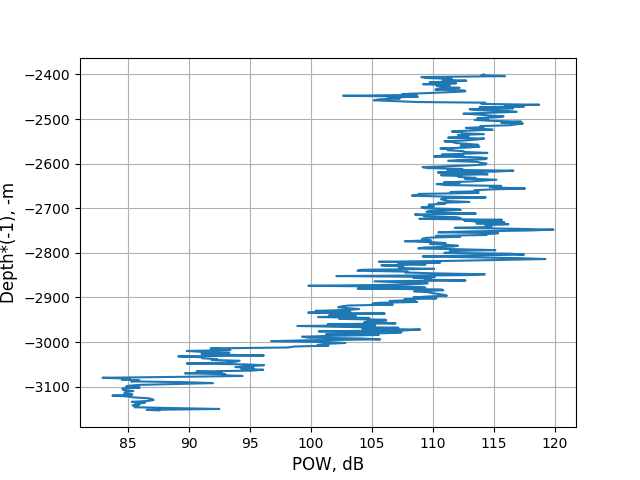

In [27]:
%matplotlib notebook

plt.plot(POW, DEPTH*(-1))
plt.xlabel('POW, dB', fontsize = 12)
plt.ylabel('Depth*(-1), -m', fontsize = 12)
plt.grid()
plt.show()

## Визуализация расхода флюида на разных глубинах 2400 - 3100 м.

<IPython.core.display.Javascript object>


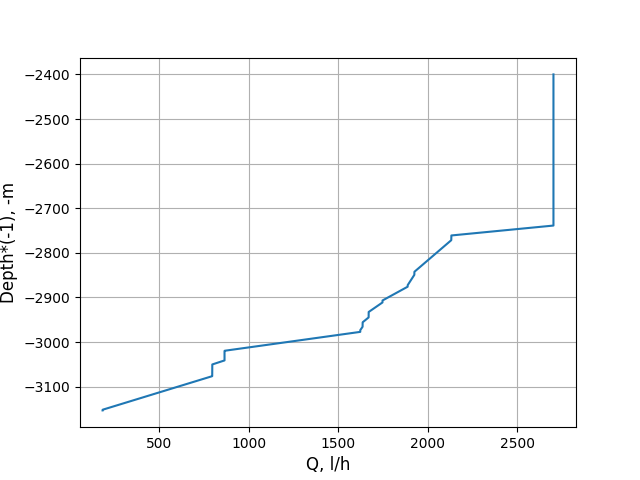

In [330]:
plt.plot(SPEED*(-1), DEPTH_SP*(-1))
plt.xlabel('Q, l/h', fontsize = 12)
plt.ylabel('Depth*(-1), -m', fontsize = 12)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


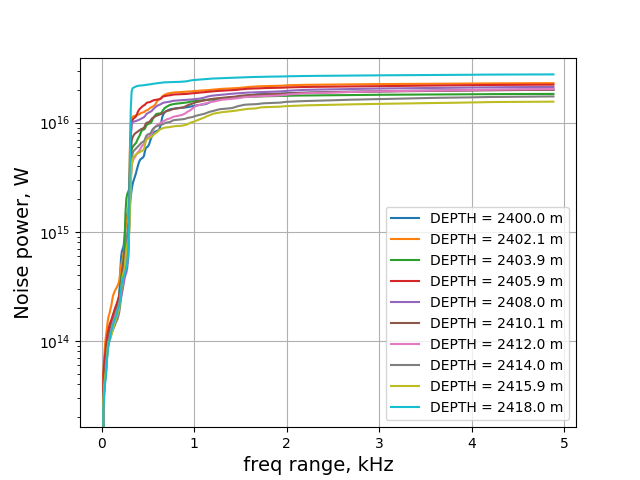

In [12]:

'''
Функция return_freq принимает SNL панели в формате .las
И извлекает частоты из описания. Регулярка ТОЛЬКО ДЛЯ LFP, форматы *.***
'''

def return_freq(las_file):
    freq = []
    for i in range(1, 513):
        freq.append(float(re.findall(r'\d\.\d{3}\b', las_snl.curves[i]['descr'])[0]))
    return np.array(freq)


def dBToPow(data):
    return 10**(data/10)
                
                
freq = return_freq(las)

fig, ax = plt.subplots() 
for j in range(10):
    y = df_snl.loc[df_snl_T.columns[j]][0:512].to_numpy()
    y = dBToPow(y)          
    pow_freq = [np.sum(y[:i]) for i in range(512)]
    ax.plot(freq, pow_freq)
    
plt.grid()
ax.set_xlabel(' freq range, kHz    ',
              fontsize = 14,    #  размер шрифта
              color = 'black')     #  ширина крайней линии


ax.set_ylabel(' Noise power, W ',
              fontsize = 14,
              color = 'black')
plt.yscale('log')
plt.legend(([f'DEPTH = {las_snl.data[:,0][k]} m' for k in range(10)]))
plt.show()

<IPython.core.display.Javascript object>


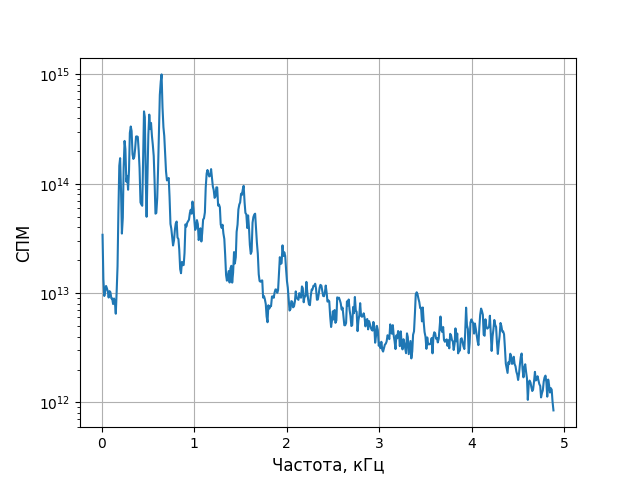

In [119]:
spm_2400 = df_snl_T[2400][:512] ### Профиль СПМ на глубине 2400 м.

'''
Профиль СПМ, DEPTH = 2400 m

'''

plt.plot(freq, dBToPow(spm_2400))
plt.xlabel('Частота, кГц', fontsize = 12)
plt.ylabel('СПМ', fontsize = 12)
plt.yscale('log')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


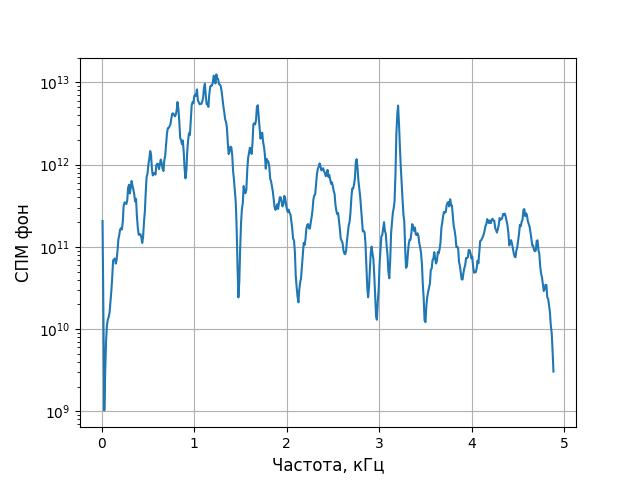

In [36]:
'''
Профиль СПМ фонового шума
За background возьму СПМ при минимальном расходе (Нуля в данных нет)

'''


spm_bg = df_snl_T[3153.1][:512]


plt.plot(freq, dBToPow(spm_bg))
plt.xlabel('Частота, кГц', fontsize = 12)
plt.ylabel('СПМ фон', fontsize = 12)
plt.yscale('log')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


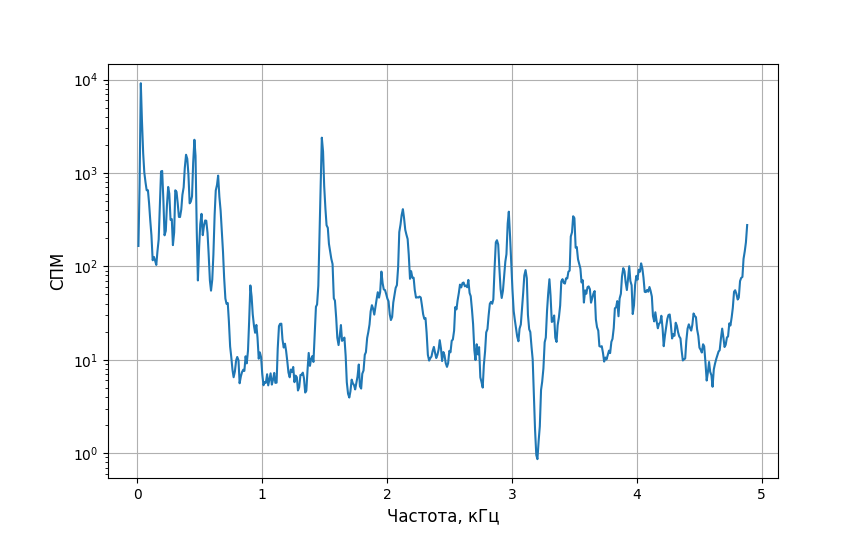

In [111]:
'''
Визуализация СПМ - background, интересует частотный разброс 

'''


plt.plot(freq, dBToPow(spm_2400-spm_bg))
plt.xlabel('Частота, кГц', fontsize = 12)
plt.ylabel('СПМ', fontsize = 12)
plt.yscale('log')
plt.grid()
plt.show()

In [129]:
spm_2400_NoBg = np.array(dBToPow(spm_2400-spm_bg))

index_min = argrelextrema(spm_2400_NoBg, np.less)[0]
index_min = index_min[index_min < 100]
arg_min = np.argmin(spm_2400_NoBg[index_min])
print(freq[index_min[arg_min]])

0.296


<IPython.core.display.Javascript object>


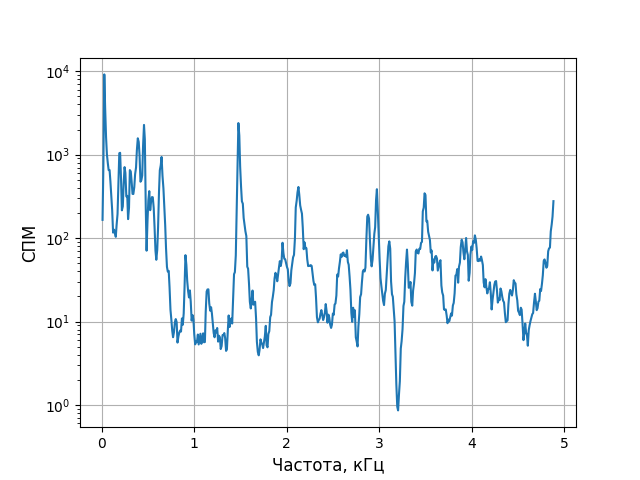

In [307]:
spm_2400 = df_snl_T[2400][:512] ### Профиль СПМ на глубине 2400 м.

plt.plot(freq, dBToPow(spm_2400-spm_bg))

plt.xlabel('Частота, кГц', fontsize = 12)
plt.ylabel('СПМ', fontsize = 12)
plt.yscale('log')
plt.grid()
plt.show()

## Частотный диапазон в зависимости от глубины 

<IPython.core.display.Javascript object>


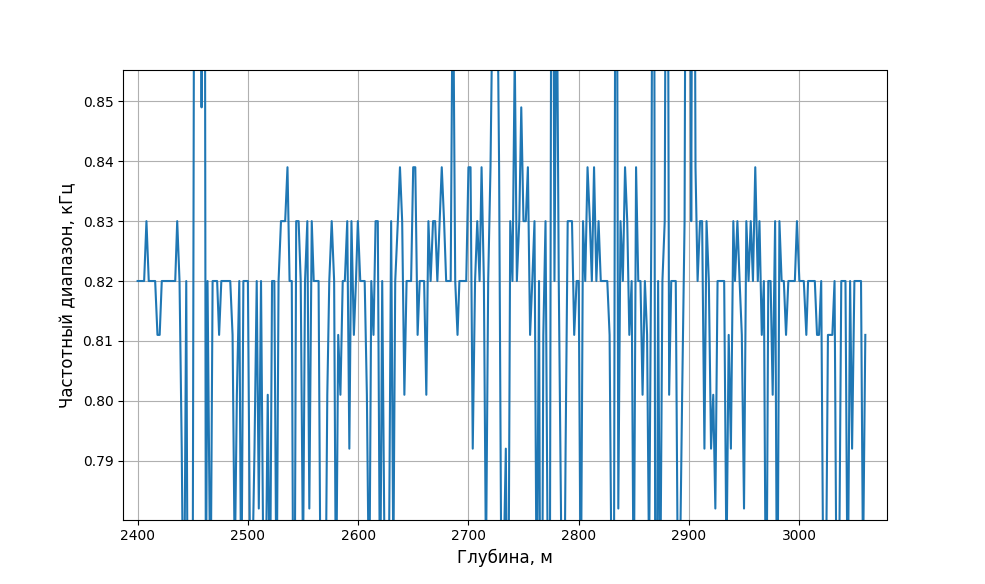

In [377]:
'''
Функция freq_range принимает DataFrame SNL и её глубину 
Необходимо будет циклом пробежать по всей глубине скважины

'''


def freq_range(data, depth):
    data = data.transpose()
    
    ### depth - абсолютная величина глубины, не индекс
    spm = data[depth][:512]
    spm_NoBg = np.array(dBToPow(spm-spm_bg))
    index_min = argrelextrema(spm_NoBg, np.less)[0]
    
    ### Ограничение " < 100 " -- условное, т.к. соответствует частотам меньше 1 кГц
    index_min = index_min[index_min < 100]
    arg_min = np.argmin(spm_NoBg[index_min])
    
    return freq[index_min[arg_min]]


'''
Профиль СПМ фонового шума
За background возьму СПМ при минимальном расходе (Нуля в данных нет)

'''
spm_bg = df_snl_T[3153.1][:512]

freq_range(df_snl, 2400)


freq_range_list = [freq_range(df_snl, i) for i in DEPTH[:376]]

plt.plot(DEPTH[:330], freq_range_list[:330])
plt.ylabel('Частотный диапазон, кГц', fontsize = 12)
plt.xlabel('Глубина, м', fontsize = 12)
plt.grid()
plt.show()

In [349]:
DEPTH  ### range 0.082 kHz (2400 m)

Q = df_qzi.loc[DEPTH[:330]]*(-1) ### Расход флюида для глубин DEPTH

'''
Вычисляем мощность учитывая индивидуальные частотные границы
Области с низким расходом отсекаем, т.к. их амплитуды аналогичны фону

'''


snl_pow = [np.sum(df_snl_T[DEPTH[i]][:len(freq[freq < freq_range_list[i]])]) for i in range(376)][:330]

<IPython.core.display.Javascript object>


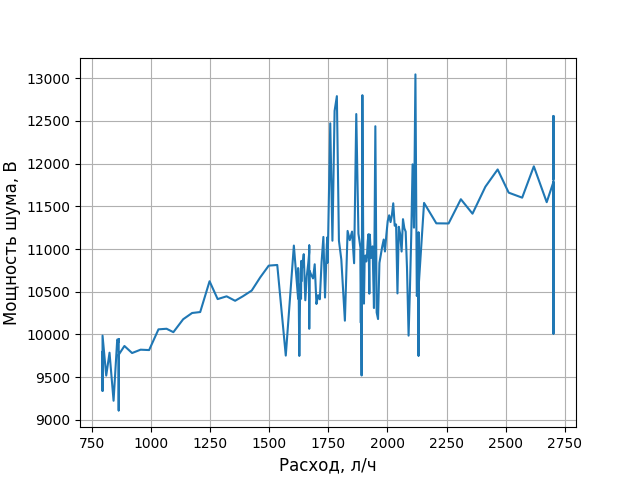

In [352]:
plt.plot(Q, snl_pow)
plt.ylabel('Мощность шума, В', fontsize = 12)
plt.xlabel('Расход, л/ч', fontsize = 12)
'''plt.yscale('log')
plt.xscale('log')'''
plt.grid()
plt.show()

# Объединил в единое окно -- Алгоритм нахождения зависимости мощности шума от расхода
## Для каждой глубины вычисляется свой частотный диапазон, мощность рассчитывается только по этому диапазону

<IPython.core.display.Javascript object>


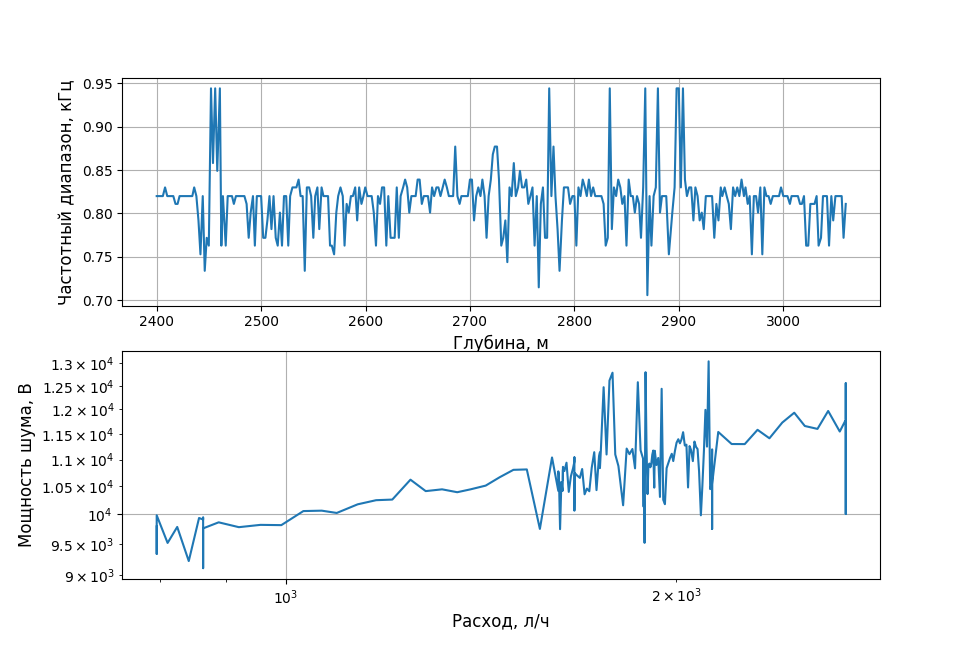

In [2]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import argrelextrema

%matplotlib notebook

'''
Функция return_freq принимает SNL панели в формате .las
И извлекает частоты из описания. Регулярка ТОЛЬКО ДЛЯ LFP, форматы *.***
'''

def return_freq(las_file):
    freq = []
    for i in range(1, 513):
        freq.append(float(re.findall(r'\d\.\d{3}\b', las_snl.curves[i]['descr'])[0]))
    return np.array(freq)


def dBToPow(data):
    return 10**(data/10)

'''
Функция freq_range принимает DataFrame SNL и её глубину 
Необходимо будет циклом пробежать по всей глубине скважины

'''


def freq_range(data, depth):
    data = data.transpose()
    
    ### depth - абсолютная величина глубины, не индекс
    spm = data[depth][:512]
    spm_NoBg = np.array(dBToPow(spm-spm_bg))
    index_min = argrelextrema(spm_NoBg, np.less)[0]
    
    ### Ограничение " < 100 " -- условное, т.к. соответствует частотам меньше 1 кГц
    index_min = index_min[index_min < 100]
    arg_min = np.argmin(spm_NoBg[index_min])
    
    return freq[index_min[arg_min]]


'''
В файле QZI.las лежит информация о расходе флюза по всей глубине скважины. 
LFP_FLOWING.las -- SNL панели, полученные в MAXIM

'''

las = lasio.read('LFP_POW_3201.las')
las_qzi = lasio.read('QZI.las')
las_snl = lasio.read('LFP_FLOWING_3402.las')

df = las.df()
df_qzi = las_qzi.df()
df_snl = las_snl.df()
df_snl_T = df_snl.transpose()
freq = return_freq(las)

DEPTH = las.index
POW = np.array(df['POW'])
SPEED = np.array(df_qzi['QZI_SIM-COPY'][2400:3153.1])
DEPTH_SP = np.array(df_qzi[2400:3153.1].index)
Q = df_qzi.loc[DEPTH[:330]]*(-1) ### Расход флюида для глубин DEPTH


'''
spm_bg - профиль СПМ фонового шума
За background возьму СПМ при минимальном расходе (Нуля в данных нет)

'''
spm_bg = df_snl_T[3153.1][:512]

freq_range_list = [freq_range(df_snl, i) for i in DEPTH[:376]]


'''
Вычисляем мощность учитывая индивидуальные частотные границы
Области с низким расходом отсекаем, т.к. их амплитуды аналогичны фону

'''
snl_pow = [np.sum(df_snl_T[DEPTH[i]][:len(freq[freq < freq_range_list[i]])]) for i in range(376)][:330]


plt.subplot(2, 1, 1)
plt.plot(DEPTH[:330], freq_range_list[:330])
plt.grid()
plt.ylabel('Частотный диапазон, кГц', fontsize = 12)
plt.xlabel('Глубина, м', fontsize = 12)

plt.subplot(2, 1, 2)
plt.plot(Q, snl_pow)
plt.ylabel('Мощность шума, В', fontsize = 12)
plt.xlabel('Расход, л/ч', fontsize = 12)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()


## Для всех глубин один и тот же частотный диапазон, мощность рассчитывается по одному диапазону -- эффективному по предыдущему алгоритму

<IPython.core.display.Javascript object>


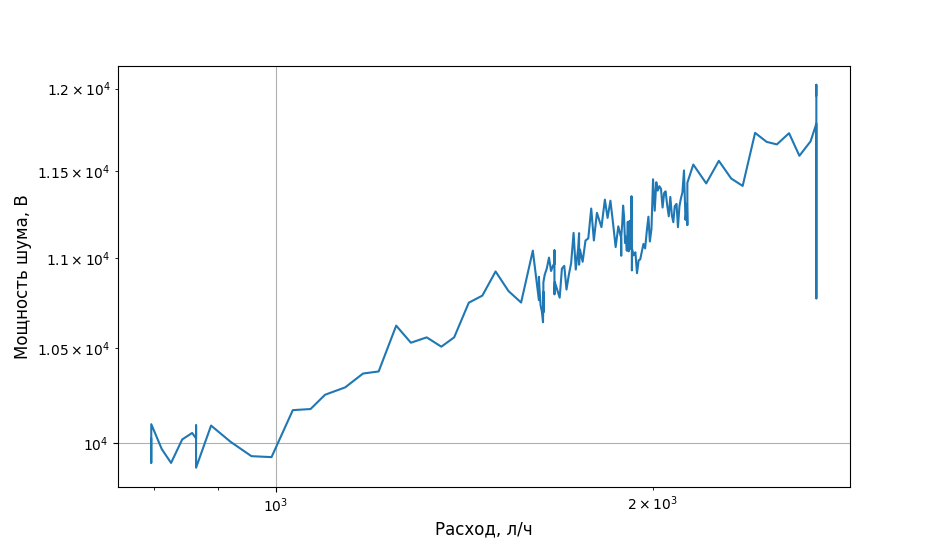

In [141]:
snl_pow = [np.sum(df_snl_T[DEPTH[i]][:len(freq[freq <= 0.82])]) for i in range(376)][:330]

plt.plot(Q, snl_pow)
plt.ylabel('Мощность шума, В', fontsize = 12)
plt.xlabel('Расход, л/ч', fontsize = 12)
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

## Подбор частотного диапазона, мощность рассчитывается по одному диапазону

In [35]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import argrelextrema

%matplotlib notebook

'''
Функция return_freq принимает SNL панели в формате .las
И извлекает частоты из описания. Регулярка ТОЛЬКО ДЛЯ LFP, форматы *.***
'''

def return_freq(las_file):
    freq = []
    for i in range(1, 513):
        freq.append(float(re.findall(r'\d\.\d{3}\b', las_snl.curves[i]['descr'])[0]))
    return np.array(freq)


def dBToPow(data):
    return 10**(data/10)


'''
В файле QZI.las лежит информация о расходе флюза по всей глубине скважины. 
LFP_FLOWING.las -- SNL панели, полученные в MAXIM

'''

las = lasio.read('LFP_POW_3201.las')
las_qzi = lasio.read('QZI.las')
las_snl = lasio.read('LFP_FLOWING_3402.las')

df = las.df()
df_qzi = las_qzi.df()
df_snl = las_snl.df()
df_snl_T = df_snl.transpose()
freq = return_freq(las)

DEPTH = las.index
POW = np.array(df['POW'])
SPEED = np.array(df_qzi['QZI_SIM-COPY'][2400:3153.1])
DEPTH_SP = np.array(df_qzi[2400:3153.1].index)
Q = df_qzi.loc[DEPTH[:330]]*(-1) ### Расход флюида для глубин DEPTH


'''
spm_bg - профиль СПМ фонового шума
За background возьму СПМ при минимальном расходе (Нуля в данных нет)

'''
spm_bg = df_snl_T[3153.1][:512]

freq_range_list = [freq_range(df_snl, i) for i in DEPTH[:376]]


<IPython.core.display.Javascript object>


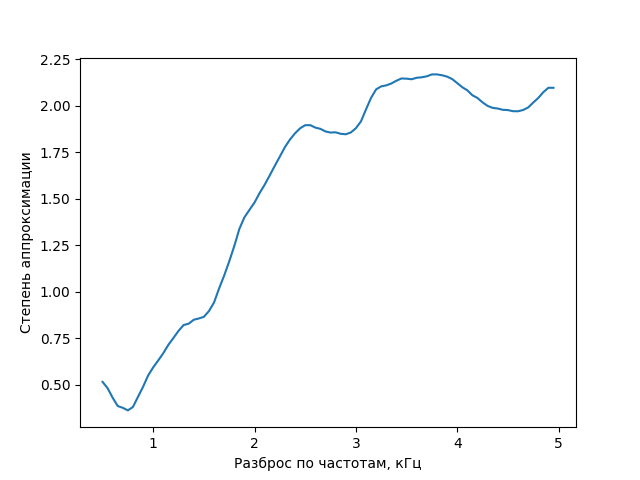

Text(0.5, 0, 'Разброс по частотам, кГц')

In [58]:
from scipy.optimize import curve_fit

def func(x,a, b, c):
    return b*(x**a)+c
pow_range = []

for j in np.arange(0.5, 5.0, 0.05):
    snl_pow = [np.sum((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= j])]) for i in range(376)][:330]
    popt, pcov = curve_fit(func, np.array(Q['QZI_SIM-COPY']), snl_pow[0:330])
    pow_range.append(popt[0])
    #print(f'Степень: {popt[0]} при частотном разбросе: {j} kHz')
    
plt.plot(np.arange(0.5, 5.0, 0.05), pow_range)
plt.ylabel('Степень аппроксимации')
plt.xlabel('Разброс по частотам, кГц')

<IPython.core.display.Javascript object>


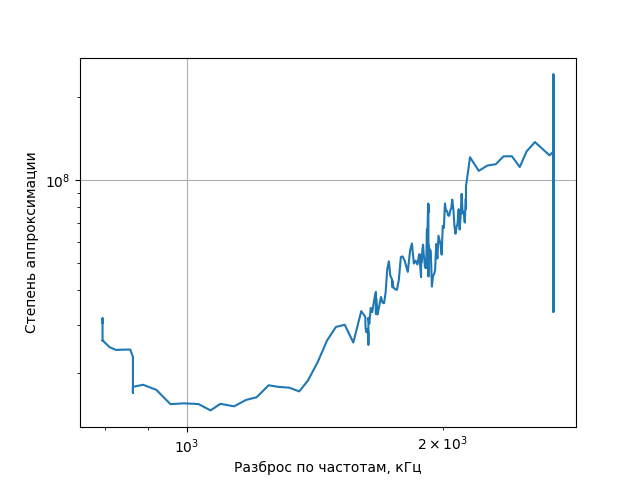

In [141]:
from scipy.optimize import curve_fit

def func(x,a, b, c):
    return b*(x**a)+c
pow_range = []
snl_pow = []

for j in np.arange(0.5, 5.0, 0.05):
    global snl_pow
    snl_pow = [np.sum(dBTomV((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= j])])[50:]) for i in range(376)]
    #popt, pcov = curve_fit(func, np.array(Q['QZI_SIM-COPY']), snl_pow[0:330])
    #pow_range.append(popt[0])
    #print(f'Степень: {popt[0]} при частотном разбросе: {j} kHz')
    
#plt.plot(np.arange(0.5, 5.0, 0.05), pow_range)
plt.plot(np.array(Q['QZI_SIM-COPY']), snl_pow[0:330])
plt.ylabel('Степень аппроксимации')
plt.xlabel('Разброс по частотам, кГц')
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [114]:
[np.sum(dBTomV((df_snl_T[DEPTH[1]][:512]-spm_bg)[:len(freq[freq <= 3])]))]

[200665722.011929]

In [113]:
def dBTomV(data):
    return (2**16)*10**(data/20)

In [79]:
len(df_snl_T[DEPTH[1]][:512]-spm_bg)

512

In [136]:
len(Q)

330

## Зависимость мощности шума от расхода Q в двойной логарифмической шкале
### Мощность переводил в мВатт по формуле (2^16)*10^(data/20)
### Расход Q неизвестно в каких величинах

<IPython.core.display.Javascript object>


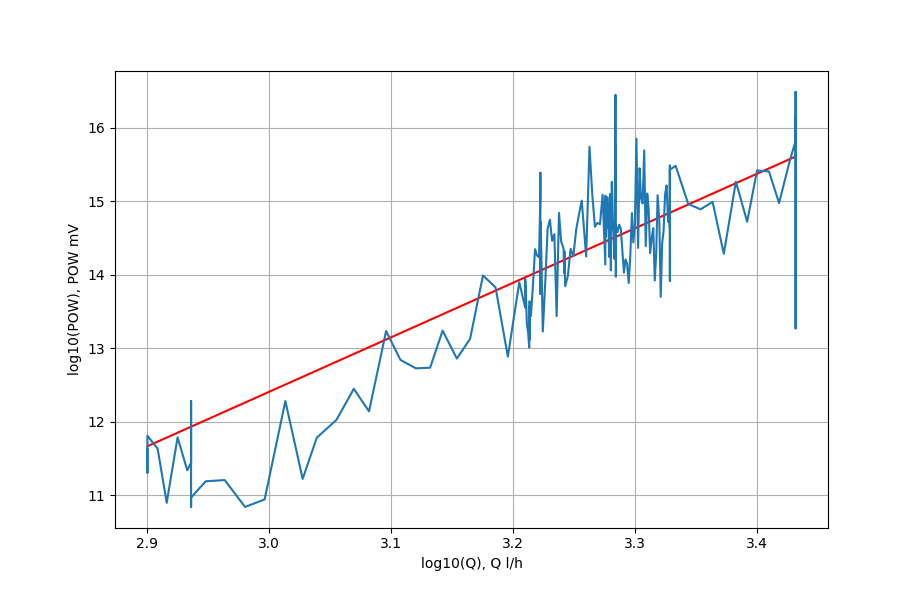

Степень= 8.604, df= 0.5 kHz, СКО=1.295483503421522
Степень= 7.903, df= 0.6 kHz, СКО=0.8799593443571451
Степень= 7.326, df= 0.7 kHz, СКО=0.7834087088831433
Степень= 7.319, df= 0.8 kHz, СКО=0.7794116467303713
Степень= 7.338, df= 0.9 kHz, СКО=0.7735547780526314
Степень= 7.404, df= 1.0 kHz, СКО=0.7620395716088357
Степень= 7.409, df= 1.1 kHz, СКО=0.7612198733361494
Степень= 7.414, df= 1.2 kHz, СКО=0.7608514507938997
Степень= 7.414, df= 1.3 kHz, СКО=0.7607662959761119
Степень= 7.419, df= 1.4 kHz, СКО=0.7601380121022956
Степень= 9.489, df= 1.5 kHz, СКО=0.7087108780694504
Степень= 9.514, df= 1.6 kHz, СКО=0.7083807698281469
Степень= 9.514, df= 1.7 kHz, СКО=0.7083568778627759
Степень= 9.514, df= 1.8 kHz, СКО=0.7083379170004379
Степень= 9.515, df= 1.9 kHz, СКО=0.7081657357466732
Степень= 9.521, df= 2.0 kHz, СКО=0.7075568369818088
Степень= 9.55, df= 2.1 kHz, СКО=0.7056711273962734
Степень= 9.689, df= 2.2 kHz, СКО=0.6976280383198539
Степень= 9.694, df= 2.3 kHz, СКО=0.6973585591098416
Степень= 9.695

In [125]:
from scipy.optimize import curve_fit

def func(x,a, b, c):
    return b*(x**a)+c

def dBTomV(data):
    return (2**16)*10**(data/10)

def lin_func(x, a, b):
    return a*x+b

snl_pow = [np.sum(dBTomV((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= 1.4])])[50:]**2) for i in range(376)]

x = np.log10(np.array(Q['QZI_SIM-COPY']))
y = lin_func(x, 7.419, -9.851)
plt.plot(x,y, "red")

plt.plot(np.log10(np.array(Q['QZI_SIM-COPY'])), np.log10(snl_pow[0:330]))
plt.ylabel('log10(POW), POW mV')
plt.xlabel('log10(Q), Q l/h')
plt.grid()
plt.show()

sko = []
power = []

for j in np.arange(0.5, 5, 0.1):
    snl_pow = [np.sum(dBTomV((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= j])])[50:]**2) for i in range(376)]
    popt, pcov = curve_fit(lin_func, np.log10(np.array(Q['QZI_SIM-COPY']))[:300], np.log10(snl_pow[:300]))
    sko.append(np.sqrt(np.diag(pcov))[1]-np.sqrt(np.diag(pcov))[0])
    power.append(float("{0:.3f}".format(popt[0])))
    print(f'Степень= {float("{0:.3f}".format(popt[0]))}, df= {float("{0:.3f}".format(j))} kHz, СКО={np.sqrt(np.diag(pcov))[1]-np.sqrt(np.diag(pcov))[0]}')

## Зависимость СКО аппроксимации от частотного диапазона

<IPython.core.display.Javascript object>


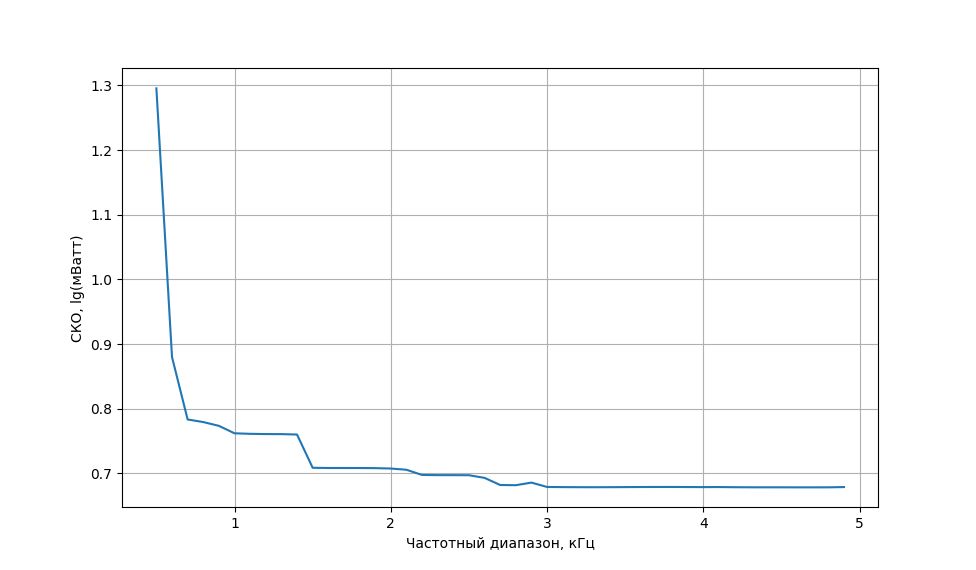

In [124]:
plt.plot(np.arange(0.5, 5, 0.1), sko)
plt.ylabel('СКО, lg(мВатт)')
plt.xlabel('Частотный диапазон, кГц')
plt.grid()
plt.show()

## Зависимость степени аппроксимации от частотного диапазона

<IPython.core.display.Javascript object>


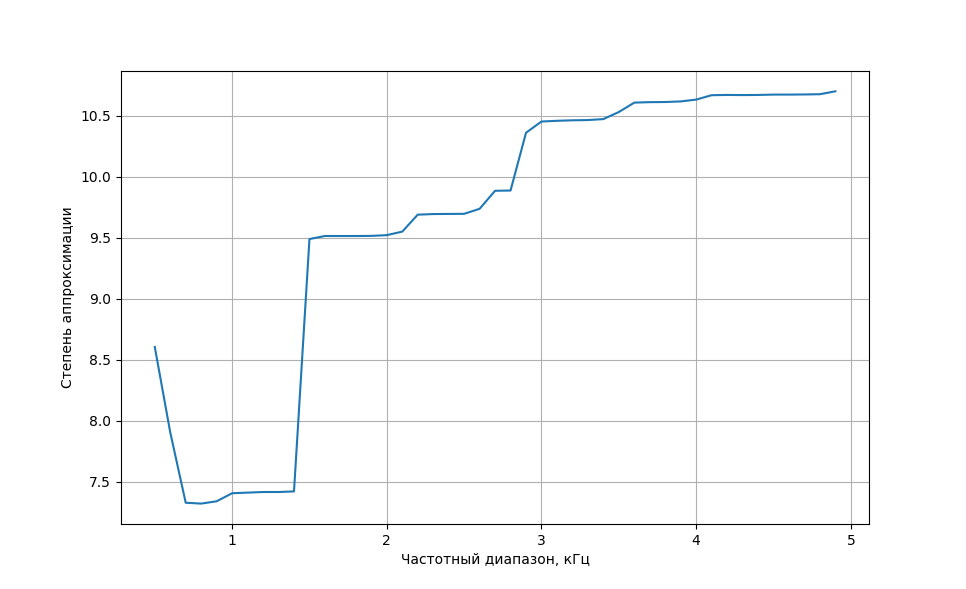

In [126]:
plt.plot(np.arange(0.5, 5, 0.1), power)
plt.ylabel('Степень аппроксимации')
plt.xlabel('Частотный диапазон, кГц')
plt.grid()
plt.show()

In [173]:
dict_api =  {'range': "'Лист номер один'!F2:M13", 'majorDimension': 'COLUMNS', 'values': [['К484АР', '8:00 - 9:00', '9:00 - 10:00', '10:00 - 11:00', '11:00 - 12:00', '12:00 - 13:00', '13:00 - 14:00', '14:00 - 15:00', '15:00 - 16:00', '16:00 - 17:00', '17:00 - 18:00'], ['Понедельник', '', '620139448'], ['Вторник', '', '', '', '', '620139448', '', '', '620139448'], ['Среда'], ['Четверг', '', '', '', '', '620139448'], ['Пятница'], ['Суббота'], ['Воскресенье', '', '', '', '', '', '', '', '', '', '620139448']]}

In [188]:
dict_api['values']

[['К484АР',
  '8:00 - 9:00',
  '9:00 - 10:00',
  '10:00 - 11:00',
  '11:00 - 12:00',
  '12:00 - 13:00',
  '13:00 - 14:00',
  '14:00 - 15:00',
  '15:00 - 16:00',
  '16:00 - 17:00',
  '17:00 - 18:00'],
 ['Понедельник', '', '620139448'],
 ['Вторник', '', '', '', '', '620139448', '', '', '620139448'],
 ['Среда'],
 ['Четверг', '', '', '', '', '620139448'],
 ['Пятница'],
 ['Суббота'],
 ['Воскресенье', '', '', '', '', '', '', '', '', '', '620139448']]

In [198]:
message_timetable = []

dict_bd = {
    ('col', 1): 'Номер авто: ', ('col', 2): 'Понедельник', ('col', 3): 'Вторник', ('col', 4): 'Среда', 
    ('col', 5): 'Четверг', ('col', 6): 'Пятница', ('col', 7): 'Суббота', ('col', 8): 'Воскресенье', 
    ('row', 2): '8:00 - 9:00', ('row', 3): '9:00 - 10:00', ('row', 4): '10:00 - 11:00', ('row', 5): '11:00 - 12:00', 
    ('row', 6): '12:00 - 13:00', ('row', 7): '13:00 - 14:00', ('row', 8): '14:00 - 15:00', ('row', 9): '15:00 - 16:00', 
    ('row', 10): '16:00 - 17:00', ('row', 11): '17:00 - 18:00', 
          }

def dict_get(i, j):
    col = dict_bd.get(('col', i))
    row = dict_bd.get(('row', j))
    return f'{col}: {row}'

for i in range(len(dict_api['values'])):
    for j in range(len(dict_api['values'][i])):
        if dict_api['values'][i][j] == '620139448':
            print(dict_get(i+1, j+1))
            message_timetable.append(dict_get(i+1, j+1))

Понедельник: 9:00 - 10:00
Вторник: 12:00 - 13:00
Вторник: 15:00 - 16:00
Четверг: 12:00 - 13:00
Воскресенье: 17:00 - 18:00


In [176]:
dict_bd = {
    ('col', 1): 'Номер авто: ', ('col', 2): 'Понедельник', ('col', 3): 'Вторник', ('col', 4): 'Среда', 
    ('col', 5): 'Четверг', ('col', 6): 'Пятница', ('col', 7): 'Суббота', ('col', 8): 'Воскресенье', 
    ('row', 2): '8:00 - 9:00', ('row', 3): '9:00 - 10:00', ('row', 4): '10:00 - 11:00', ('row', 5): '11:00 - 12:00', 
    ('row', 6): '12:00 - 13:00', ('row', 7): '13:00 - 14:00', ('row', 8): '14:00 - 15:00', ('row', 9): '15:00 - 16:00', 
    ('row', 10): '16:00 - 17:00', ('row', 11): '17:00 - 18:00', 
          }

In [190]:
dict_bd.get(('col', 2)), dict_bd.get(('row', 3))

('Понедельник', '9:00 - 10:00')

In [224]:
a = [f'Понедельник: 8:00 - 9:00 ', 'Понедельник: 11:00 - 12:00', 'Вторник: 12:00 - 13:00', 'Среда: 8:00 - 9:00', 'Четверг: 14:00 - 15:00', 'Суббота: 11:00 - 12:00', 'Воскресенье: 15:00 - 16:00']

In [225]:
a

['Понедельник: 8:00 - 9:00 \\n',
 'Понедельник: 11:00 - 12:00',
 'Вторник: 12:00 - 13:00',
 'Среда: 8:00 - 9:00',
 'Четверг: 14:00 - 15:00',
 'Суббота: 11:00 - 12:00',
 'Воскресенье: 15:00 - 16:00']

In [228]:
b = "Hello\nWorld!"
b

'Hello\nWorld!'